In time series literature, common features created:
1. Date / time related features
1. Lag features
1. Rolling window feature
1. Domain specific features

In [1]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np
import xgboost as xgb

from plotly.subplots import make_subplots
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, precision_score

from sktime.transformations.series.detrend import STLTransformer

from utils.common import read_bm_data, plot_confusion_matrix
from utils.features import compute_z_past, create_lag, create_rsi, create_dst, create_ma_ratio, create_z

import os
import ta
import tabulate
import datetime
import tqdm
import pickle

In [2]:
df_wti_1m = pickle.load(open('./large_files/cl-1m.pkl', 'rb'))
df_wti_1m = df_wti_1m[(df_wti_1m['datetime'].dt.hour >= 8) & (df_wti_1m['datetime'].dt.hour <= 16)]

# df_wti = read_bm_data('./data/backtestmarket/cl-15m.csv')

# df = df_wti.copy()
# df = df[(df['datetime'].dt.hour >= 8) & (df['datetime'].dt.hour < 16)]
# df = df[(df['datetime'].dt.weekday == 2) & (df['datetime'].dt.year >= 2010) & (df['datetime'].dt.year <= 2019)]
# df.head()

In [3]:
df = df_wti_1m.copy()
df = df[(df['datetime'].dt.hour >= 8) & (df['datetime'].dt.hour < 16)]
df = df[(df['datetime'].dt.weekday == 2) & (df['datetime'].dt.year >= 2010) & (df['datetime'].dt.year <= 2019)]
df['month'] = df['datetime'].dt.month
df.head()

,date,time,open,high,low,close,volume,datetime,day,month
834818,2010-01-06,0800,81.54,81.55,81.51,81.54,393,2010-01-06 08:00:00-05:00,Wednesday,1
834819,2010-01-06,0801,81.54,81.54,81.52,81.53,156,2010-01-06 08:01:00-05:00,Wednesday,1
834820,2010-01-06,0802,81.53,81.53,81.52,81.53,47,2010-01-06 08:02:00-05:00,Wednesday,1
834821,2010-01-06,0803,81.52,81.52,81.50,81.51,32,2010-01-06 08:03:00-05:00,Wednesday,1
834822,2010-01-06,0804,81.51,81.54,81.51,81.53,27,2010-01-06 08:04:00-05:00,Wednesday,1


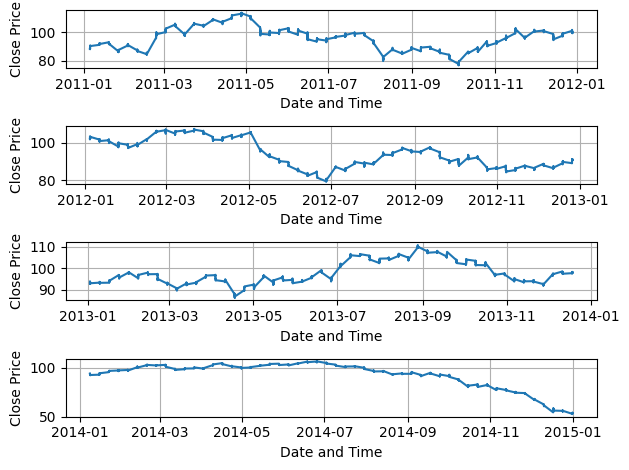

In [4]:
years = [2011, 2012, 2013, 2014]
fig, axs = plt.subplots(4, 1)

for year, ax in zip(years, axs):
    df_filter = df[df['datetime'].dt.year == year]
    ax.plot(df_filter['datetime'], df_filter['close'], linestyle='-')
    ax.set_xlabel('Date and Time')
    ax.set_ylabel('Close Price')
    # ax.set_ticks(rotation=45)
    ax.grid(True)
plt.tight_layout()
plt.show()

# Price
z: standard deviation relative to mean of past
pct: percentage change relative to mean of past
mean: mean of past
std: standard deviation of past

When computing mean of past, should we include value of current time?

In [5]:
# if os.path.isfile('./large_files/features.pkl'):
#     df = pickle.load(open('./large_files/features.pkl', 'rb'))
# else:
#     df = compute_z_past(df, df_wti_1m, 1, 0, '1hr')
#     df = compute_z_past(df, df_wti_1m, 0, 30, '30m')
#     df = compute_z_past(df, df_wti_1m, 0, 15, '15m')
#     pickle.dump(df, open('./large_files/features.pkl', 'wb'))
# df['month'] = df['datetime'].dt.month
# df.head(3)

In [6]:
df = create_z(df, 5, 'close')
df = create_z(df, 15, 'close')
df = create_z(df, 30, 'close')
df = create_z(df, 60, 'close')

df.head(3)

100%|██████████| 3634/3634 [00:00<00:00, 7274.37it/s]


,date,time,open,high,low,close,volume,datetime,day,month,...,std_close_15m,sma_close_15m,z_close_30m,pct_close_30m,std_close_30m,sma_close_30m,z_close_60m,pct_close_60m,std_close_60m,sma_close_60m
834818,2010-01-06,0800,81.54,81.55,81.51,81.54,393,2010-01-06 08:00:00-05:00,Wednesday,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
834819,2010-01-06,0801,81.54,81.54,81.52,81.53,156,2010-01-06 08:01:00-05:00,Wednesday,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
834820,2010-01-06,0802,81.53,81.53,81.52,81.53,47,2010-01-06 08:02:00-05:00,Wednesday,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lag features  

- data starts at 8am
- z_close_60m has no data from 8 - 9 am
- lag of z_close_60m won't have data from 9 - 10am

In [7]:
df = create_lag(df, 'z_close_5m', 5)
df = create_lag(df, 'z_close_5m', 15)
df = create_lag(df, 'z_close_5m', 30)
df = create_lag(df, 'z_close_5m', 60)

df = create_lag(df, 'z_close_15m', 5)
df = create_lag(df, 'z_close_15m', 15)
df = create_lag(df, 'z_close_15m', 30)
df = create_lag(df, 'z_close_15m', 60)

df = create_lag(df, 'z_close_30m', 5)
df = create_lag(df, 'z_close_30m', 15)
df = create_lag(df, 'z_close_30m', 30)
df = create_lag(df, 'z_close_30m', 60)

df = create_lag(df, 'z_close_60m', 5)
df = create_lag(df, 'z_close_60m', 15)
df = create_lag(df, 'z_close_60m', 30)
df = create_lag(df, 'z_close_60m', 60)

df.head(3)

,date,time,open,high,low,close,volume,datetime,day,month,...,lag30m_z_close_15m,lag60m_z_close_15m,lag5m_z_close_30m,lag15m_z_close_30m,lag30m_z_close_30m,lag60m_z_close_30m,lag5m_z_close_60m,lag15m_z_close_60m,lag30m_z_close_60m,lag60m_z_close_60m
0,2010-01-06,0800,81.54,81.55,81.51,81.54,393,2010-01-06 08:00:00-05:00,Wednesday,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-01-06,0801,81.54,81.54,81.52,81.53,156,2010-01-06 08:01:00-05:00,Wednesday,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-01-06,0802,81.53,81.53,81.52,81.53,47,2010-01-06 08:02:00-05:00,Wednesday,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Distance features

In [8]:
df = create_dst(df, [5, 15, 30, 60])

for i in [5, 15, 30, 60]:
    df = create_lag(df, f'dst_high_{i}m', i)
    df = create_lag(df, f'dst_low_{i}m', i)

df.head(3)

100%|██████████| 3634/3634 [00:02<00:00, 1331.65it/s]


,date,time,open,high,low,close,volume,datetime,day,month,...,dst_mean_high_60m,dst_mean_low_60m,lag5m_dst_high_5m,lag5m_dst_low_5m,lag15m_dst_high_15m,lag15m_dst_low_15m,lag30m_dst_high_30m,lag30m_dst_low_30m,lag60m_dst_high_60m,lag60m_dst_low_60m
0,2010-01-06,0800,81.54,81.55,81.51,81.54,393,2010-01-06 08:00:00-05:00,Wednesday,1,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-01-06,0801,81.54,81.54,81.52,81.53,156,2010-01-06 08:01:00-05:00,Wednesday,1,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-01-06,0802,81.53,81.53,81.52,81.53,47,2010-01-06 08:02:00-05:00,Wednesday,1,...,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Momentum indicators

In [9]:
df = create_rsi(df, [5, 10, 15, 30, 60])

100%|██████████| 3634/3634 [00:02<00:00, 1274.20it/s]


In [10]:
df = create_ma_ratio(df, 5, 15)
df = create_ma_ratio(df, 5, 30)
df = create_ma_ratio(df, 5, 60)

100%|██████████| 3634/3634 [00:00<00:00, 10046.13it/s]


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
open,247408.0,72.445582,21.880491,27.300000,52.230000,71.460000,93.530000,113.370000
high,247408.0,72.478047,21.883396,27.360000,52.260000,71.490000,93.560000,113.400000
low,247408.0,72.412957,21.877451,27.270000,52.210000,71.430000,93.500000,113.210000
close,247408.0,72.445505,21.880395,27.300000,52.230000,71.460000,93.530000,113.370000
volume,247408.0,540.265662,792.797992,1.000000,132.000000,309.000000,640.000000,25073.000000
...,...,...,...,...,...,...,...,...
rsi_30,232386.0,0.500755,0.081863,0.138680,0.447510,0.501335,0.554203,0.862720
rsi_60,216846.0,0.500415,0.062267,0.194716,0.459933,0.500615,0.541631,0.825038
ma_ratio_5_15,247408.0,0.970690,0.168684,0.000000,0.999450,0.999980,1.000467,1.018226
ma_ratio_5_30,247408.0,0.939287,0.238822,0.000000,0.998863,0.999919,1.000812,1.028035


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247408 entries, 0 to 247407
Data columns (total 78 columns):
 #   Column               Non-Null Count   Dtype                           
---  ------               --------------   -----                           
 0   date                 247408 non-null  object                          
 1   time                 247408 non-null  object                          
 2   open                 247408 non-null  float64                         
 3   high                 247408 non-null  float64                         
 4   low                  247408 non-null  float64                         
 5   close                247408 non-null  float64                         
 6   volume               247408 non-null  int64                           
 7   datetime             247408 non-null  datetime64[ns, America/New_York]
 8   day                  247408 non-null  object                          
 9   month                247408 non-null  int64     

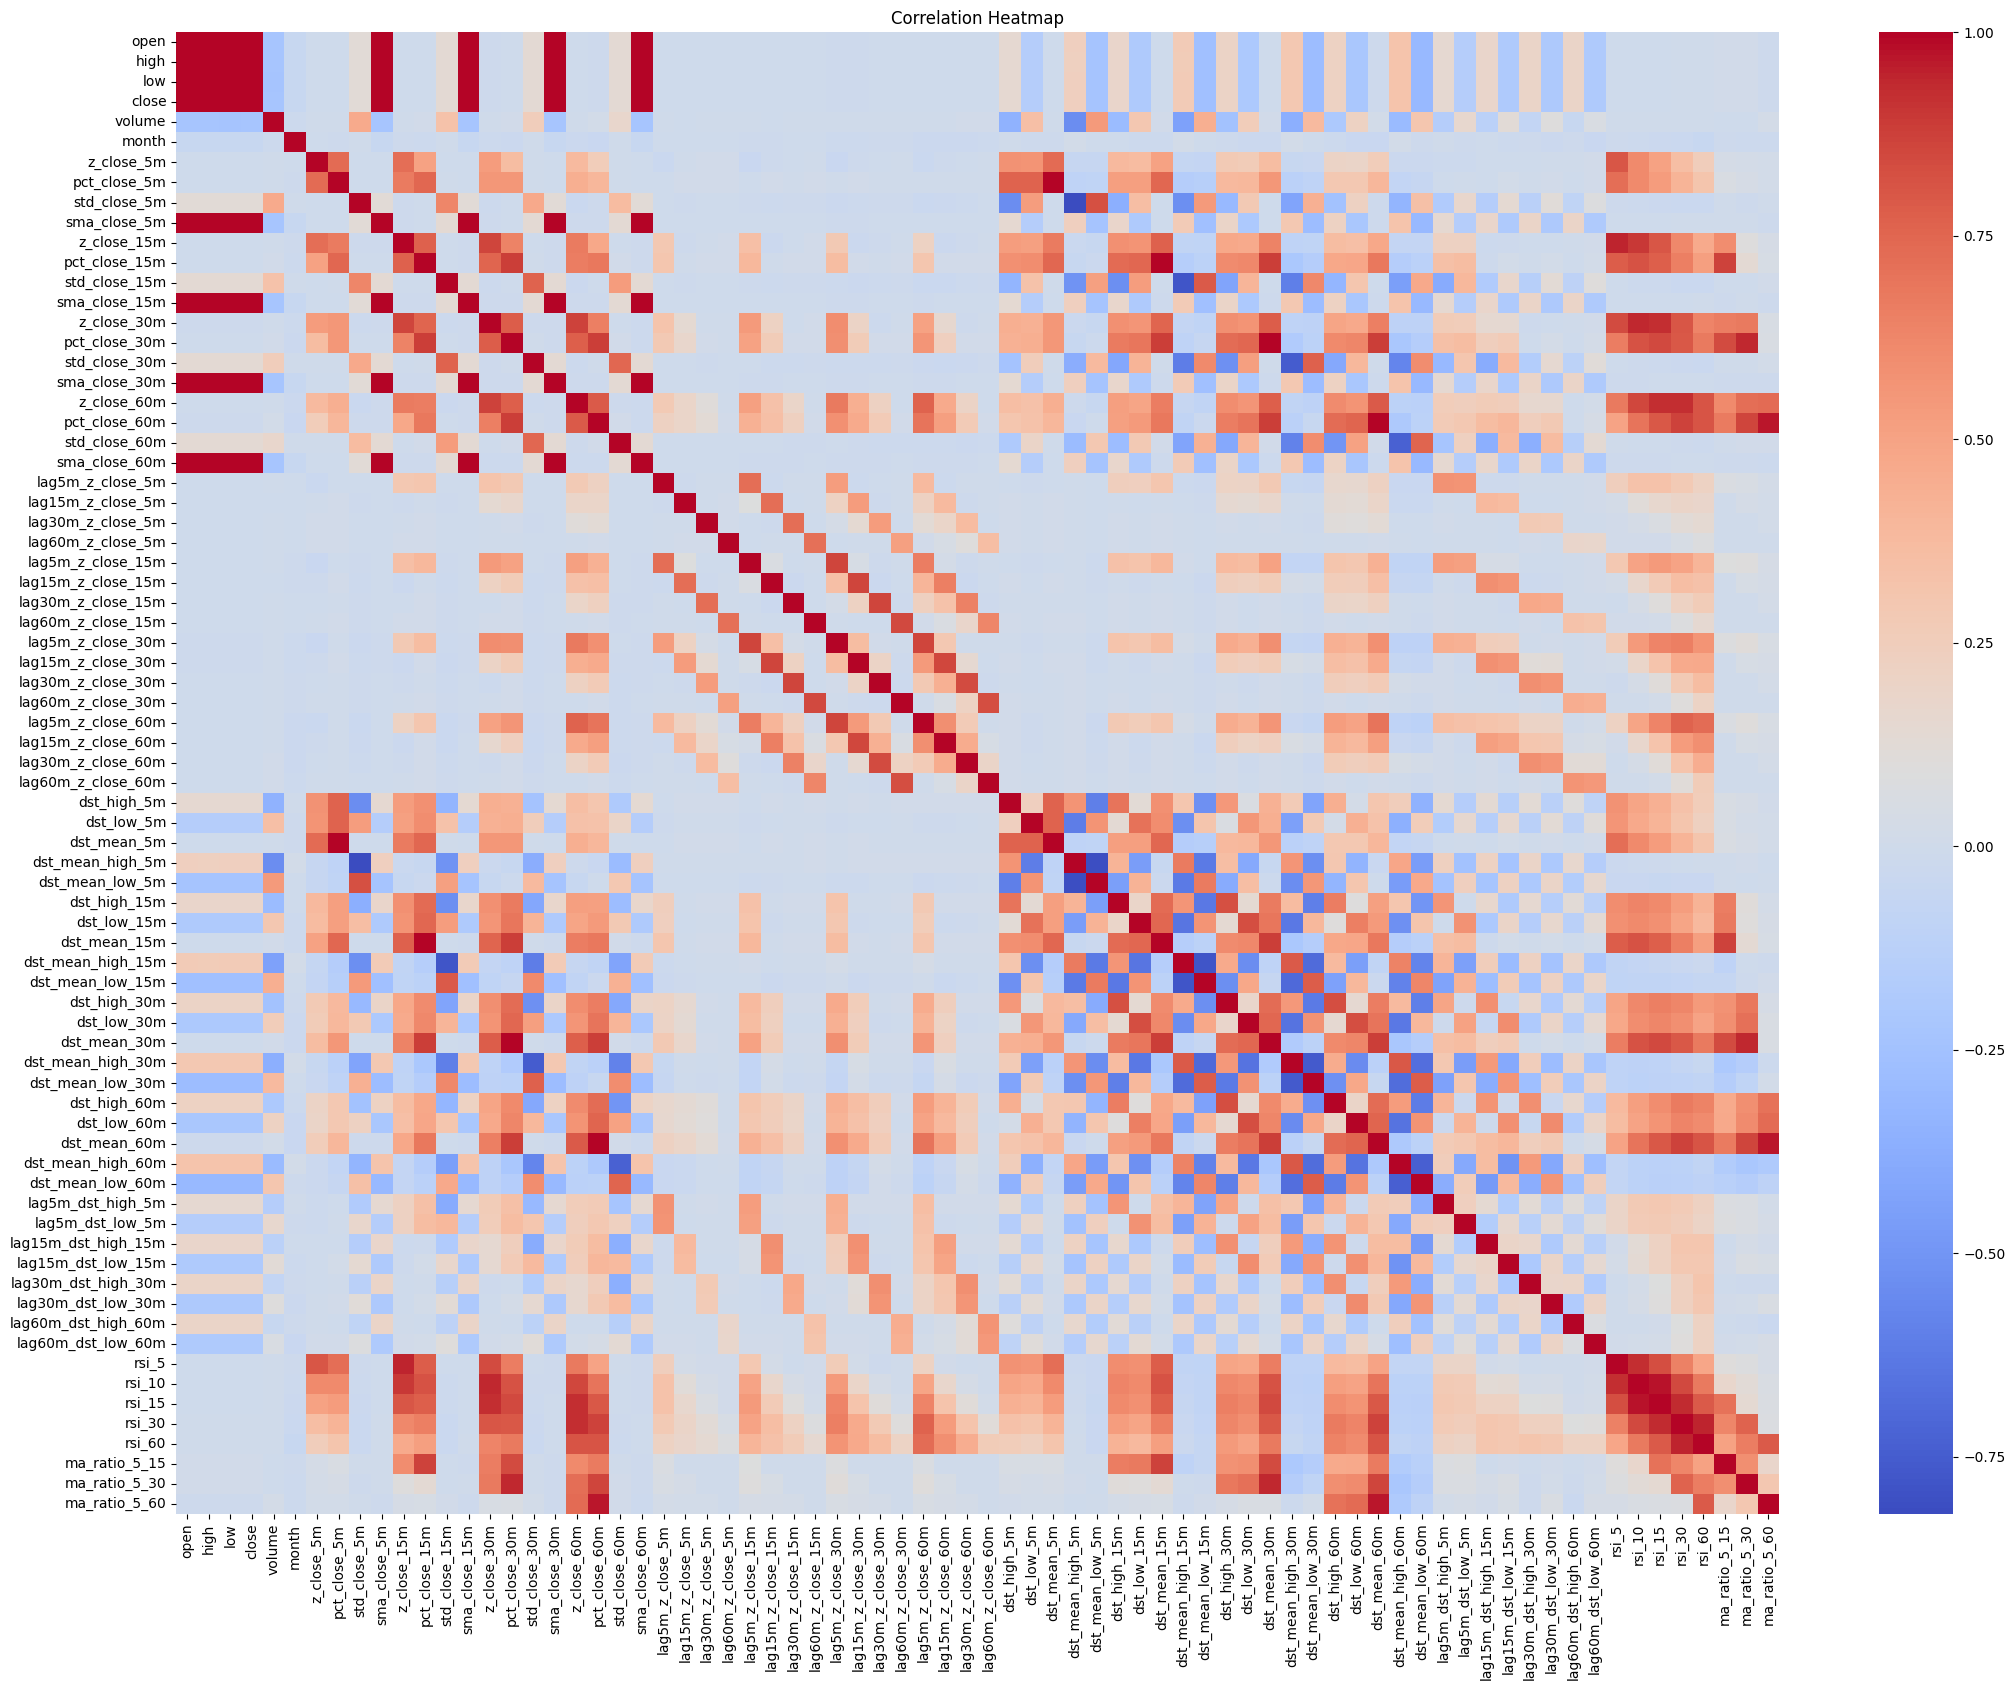

In [13]:
df2 = df[(df['datetime'].dt.time >= datetime.time(hour=9)) & (df['datetime'].dt.time < datetime.time(hour=16))]
df2 = df2.drop(['date', 'datetime', 'time', 'day'], axis=1)

plt.figure(figsize=(22, 17))

heatmap = sns.heatmap(df2.corr(numeric_only=True, method='pearson'), cmap='coolwarm', annot=False, fmt='.2f')
plt.yticks(rotation=0)

plt.title('Correlation Heatmap')
plt.tight_layout()

plt.show()

- Most low / high distance related features are negatively correlated to high / low
- dst_mean_xx mildly correlated to pct_xx
- Distance features very mildly correlated to rsi

In [14]:
corr_matrix = df2.corr(numeric_only=True, method='pearson')
threshold = 0.85

upper_triangle = corr_matrix.where(~np.tril(np.ones(corr_matrix.shape)).astype(bool))

# Find indices of highly correlated pairs
corr_pairs = np.where(abs(upper_triangle) >= threshold)

df_corr = []
for i, j in zip(*corr_pairs):
    feature1 = corr_matrix.index[i]
    feature2 = corr_matrix.columns[j]
    correlation = corr_matrix.iloc[i, j]
    df_corr.append({
        'feature1': feature1,
        'feature2': feature2,
        'correlation': correlation
    })

df_corr = pd.DataFrame(df_corr).sort_values('correlation', ascending=False).reset_index(drop=True)
print(tabulate.tabulate(df_corr, headers='keys', tablefmt='psql'))

+----+--------------------+--------------------+---------------+
|    | feature1           | feature2           |   correlation |
|----+--------------------+--------------------+---------------|
|  0 | pct_close_60m      | dst_mean_60m       |      1        |
|  1 | pct_close_5m       | dst_mean_5m        |      1        |
|  2 | pct_close_30m      | dst_mean_30m       |      1        |
|  3 | pct_close_15m      | dst_mean_15m       |      1        |
|  4 | low                | close              |      0.999998 |
|  5 | high               | close              |      0.999998 |
|  6 | open               | high               |      0.999998 |
|  7 | open               | sma_close_5m       |      0.999998 |
|  8 | open               | low                |      0.999998 |
|  9 | high               | low                |      0.999997 |
| 10 | high               | sma_close_5m       |      0.999997 |
| 11 | open               | close              |      0.999997 |
| 12 | low               

In [15]:
def get_trend(x):
    if x > 0.5:
        return 'up'
    elif x < -0.5:
        return 'down'
    else:
        return 'neutral'
    

df['trend_30m'] = df['z_close_30m'].apply(get_trend)
df.head(3)

,date,time,open,high,low,close,volume,datetime,day,month,...,lag60m_dst_low_60m,rsi_5,rsi_10,rsi_15,rsi_30,rsi_60,ma_ratio_5_15,ma_ratio_5_30,ma_ratio_5_60,trend_30m
0,2010-01-06,0800,81.54,81.55,81.51,81.54,393,2010-01-06 08:00:00-05:00,Wednesday,1,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,neutral
1,2010-01-06,0801,81.54,81.54,81.52,81.53,156,2010-01-06 08:01:00-05:00,Wednesday,1,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,neutral
2,2010-01-06,0802,81.53,81.53,81.52,81.53,47,2010-01-06 08:02:00-05:00,Wednesday,1,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,neutral


Predict trend_30m in 5 minutes

  0%|          | 0/3634 [00:00<?, ?it/s]

100%|██████████| 3634/3634 [00:00<00:00, 16597.25it/s]


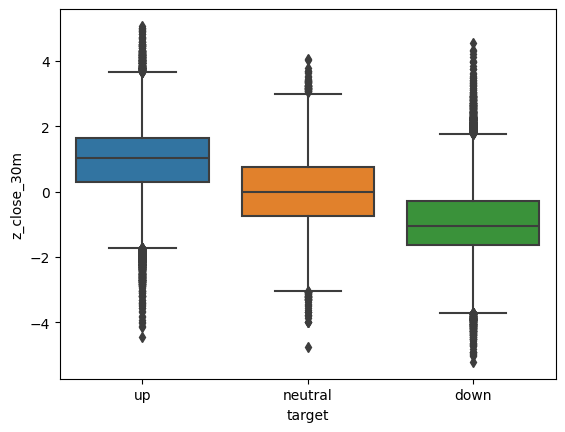

In [16]:
le = LabelEncoder()

to_drop = ['date', 'datetime', 'time', 'day', 'open', 'high', 'low', 'close', 'volume', 'target'] + \
    [f for f in df.columns if 'trend' in f] + [f for f in df.columns if 'sma' in f]

df2 = []
for day, df_day in tqdm.tqdm(df.groupby(pd.Grouper(key='datetime', freq='D'))):
    if df_day.shape[0] == 0:
        continue
    df_day = df_day.copy()
    df_day['target'] = df_day['trend_30m'].shift(-5).values
    df2.append(df_day)
df2 = pd.concat(df2)

df2 = df2[(df2['datetime'].dt.hour >= 9) & (df2['datetime'].dt.hour < 16)]
df2 = df2.dropna(axis=0)

Xtr = df2[df2['datetime'].dt.year < 2018]
Xvl = df2[df2['datetime'].dt.year == 2018]
Xte = df2[df2['datetime'].dt.year == 2019]

sns.boxplot(data=Xtr, x='target', y='z_close_30m')

ytr = le.fit_transform(Xtr['target']).reshape(-1, 1)
yvl = le.transform(Xvl['target']).reshape(-1, 1)
yte = le.transform(Xte['target']).reshape(-1, 1)

Xtr = Xtr.drop(to_drop, axis=1)
Xvl = Xvl.drop(to_drop, axis=1)
Xte = Xte.drop(to_drop, axis=1)

In [17]:
params = {
    'objective': 'multi:softmax',  
    # 'epochs': 1000, 
    'random_state': 42,
    'learning_rate': 0.05,
    'nthread': -1,
    'max_depth': 5,
    'num_class': 3,
    'early_stopping_rounds': 5
}

clf = xgb.XGBClassifier(**params)

clf.fit(
    Xtr, 
    ytr, 
    eval_set=[(Xtr, ytr), (Xvl, yvl)], 
    verbose=False
)

# Predictions on training and test sets
y_train_pred = clf.predict(Xtr)
y_test_pred = clf.predict(Xte)

# Calculate accuracy and precision scores
train_accuracy = accuracy_score(ytr, y_train_pred)
test_accuracy = accuracy_score(yte, y_test_pred)

train_precision = precision_score(ytr, y_train_pred, average='weighted')
test_precision = precision_score(yte, y_test_pred, average='weighted')

print('')
print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Training Precision: {train_precision:.2f}')
print('')
print(f'Test Accuracy: {test_accuracy:.2f}')
print(f'Test Precision: {test_precision:.2f}')


Training Accuracy: 0.63
Training Precision: 0.61

Test Accuracy: 0.65
Test Precision: 0.62


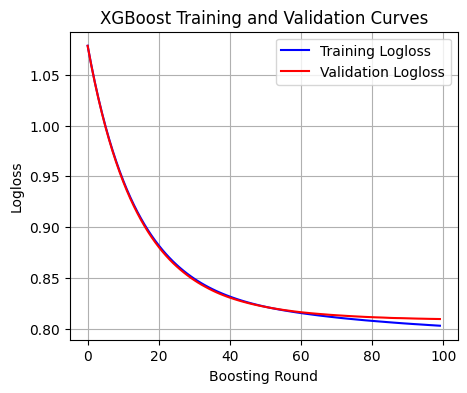

In [18]:
results = clf.evals_result()

train_logloss = results['validation_0']['mlogloss']
valid_logloss = results['validation_1']['mlogloss']

plt.figure(figsize=(5, 4))
plt.plot(train_logloss, label='Training Logloss', color='blue')
plt.plot(valid_logloss, label='Validation Logloss', color='red')
plt.xlabel('Boosting Round')
plt.ylabel('Logloss')
plt.title('XGBoost Training and Validation Curves')
plt.legend()
plt.grid(True)
plt.show()

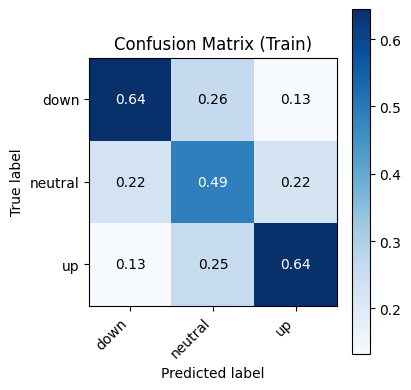

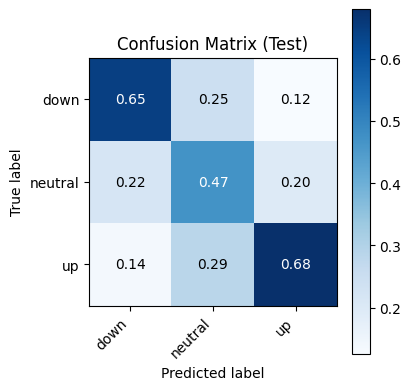

              precision    recall  f1-score   support

        down       0.65      0.80      0.71      7757
     neutral       0.47      0.11      0.18      4637
          up       0.68      0.82      0.74      8735

    accuracy                           0.65     21129
   macro avg       0.60      0.57      0.54     21129
weighted avg       0.62      0.65      0.61     21129



In [19]:
plot_confusion_matrix(ytr, y_train_pred, le.classes_, 'Confusion Matrix (Train)', normalize=True)
plot_confusion_matrix(yte, y_test_pred, le.classes_, 'Confusion Matrix (Test)', normalize=True)
print(classification_report(yte, y_test_pred, target_names=le.classes_))

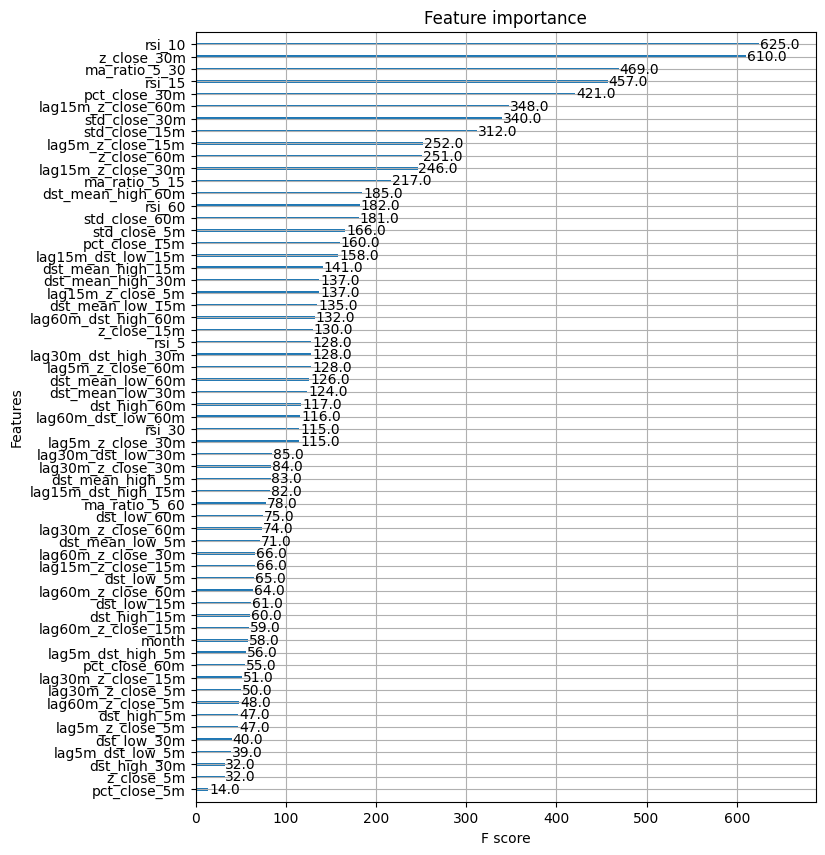

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))
xgb.plot_importance(clf, importance_type='weight', ax=ax)
plt.show()

- drop price features first before going volume?
- difference between "wednesday" model vs other days?
- p-value?
- "usefulness" of trend_30m (future 5 minutes) as target, backtesting?
- redefine up, down, neutral?

## Volume

In [21]:
df = create_z(df, 5, 'volume')
df = create_z(df, 15, 'volume')
df = create_z(df, 30, 'volume')
df = create_z(df, 60, 'volume')

df.head(3)

  0%|          | 0/3634 [00:00<?, ?it/s]

100%|██████████| 3634/3634 [00:00<00:00, 6847.87it/s]


,date,time,open,high,low,close,volume,datetime,day,month,...,std_volume_15m,sma_volume_15m,z_volume_30m,pct_volume_30m,std_volume_30m,sma_volume_30m,z_volume_60m,pct_volume_60m,std_volume_60m,sma_volume_60m
0,2010-01-06,0800,81.54,81.55,81.51,81.54,393,2010-01-06 08:00:00-05:00,Wednesday,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-06,0801,81.54,81.54,81.52,81.53,156,2010-01-06 08:01:00-05:00,Wednesday,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-06,0802,81.53,81.53,81.52,81.53,47,2010-01-06 08:02:00-05:00,Wednesday,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df = create_lag(df, 'z_volume_5m', 5)
df = create_lag(df, 'z_volume_5m', 15)
df = create_lag(df, 'z_volume_5m', 30)
df = create_lag(df, 'z_volume_5m', 60)

df = create_lag(df, 'z_volume_15m', 5)
df = create_lag(df, 'z_volume_15m', 15)
df = create_lag(df, 'z_volume_15m', 30)
df = create_lag(df, 'z_volume_15m', 60)

df = create_lag(df, 'z_volume_30m', 5)
df = create_lag(df, 'z_volume_30m', 15)
df = create_lag(df, 'z_volume_30m', 30)
df = create_lag(df, 'z_volume_30m', 60)

df = create_lag(df, 'z_volume_60m', 5)
df = create_lag(df, 'z_volume_60m', 15)
df = create_lag(df, 'z_volume_60m', 30)
df = create_lag(df, 'z_volume_60m', 60)

In [23]:
le = LabelEncoder()

to_drop = ['date', 'datetime', 'time', 'day', 'open', 'high', 'low', 'close', 'volume', 'target'] + \
    [f for f in df.columns if 'trend' in f] + [f for f in df.columns if 'sma' in f]

df2 = []
for day, df_day in tqdm.tqdm(df.groupby(pd.Grouper(key='datetime', freq='D'))):
    if df_day.shape[0] == 0:
        continue
    df_day = df_day.copy()
    df_day['target'] = df_day['trend_30m'].shift(-5).values
    df2.append(df_day)
df2 = pd.concat(df2)

df2 = df2[(df2['datetime'].dt.hour >= 9) & (df2['datetime'].dt.hour < 16)]
df2 = df2.dropna(axis=0)

Xtr = df2[df2['datetime'].dt.year < 2018]
Xvl = df2[df2['datetime'].dt.year == 2018]
Xte = df2[df2['datetime'].dt.year == 2019]

ytr = le.fit_transform(Xtr['target']).reshape(-1, 1)
yvl = le.transform(Xvl['target']).reshape(-1, 1)
yte = le.transform(Xte['target']).reshape(-1, 1)

Xtr = Xtr.drop(to_drop, axis=1)
Xvl = Xvl.drop(to_drop, axis=1)
Xte = Xte.drop(to_drop, axis=1)

100%|██████████| 3634/3634 [00:00<00:00, 19509.91it/s]


In [24]:
params = {
    'objective': 'multi:softmax',  
    # 'epochs': 1000, 
    'random_state': 42,
    'learning_rate': 0.05,
    'nthread': -1,
    'max_depth': 8,
    'num_class': 3,
    'early_stopping_rounds': 5
}

clf = xgb.XGBClassifier(**params)

clf.fit(
    Xtr, 
    ytr, 
    eval_set=[(Xtr, ytr), (Xvl, yvl)], 
    verbose=False
)

# Predictions on training and test sets
y_train_pred = clf.predict(Xtr)
y_test_pred = clf.predict(Xte)

# Calculate accuracy and precision scores
train_accuracy = accuracy_score(ytr, y_train_pred)
test_accuracy = accuracy_score(yte, y_test_pred)

train_precision = precision_score(ytr, y_train_pred, average='weighted')
test_precision = precision_score(yte, y_test_pred, average='weighted')

print('')
print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Training Precision: {train_precision:.2f}')
print('')
print(f'Test Accuracy: {test_accuracy:.2f}')
print(f'Test Precision: {test_precision:.2f}')


Training Accuracy: 0.67
Training Precision: 0.66

Test Accuracy: 0.66
Test Precision: 0.62


+1 % increment after changing depth to 8

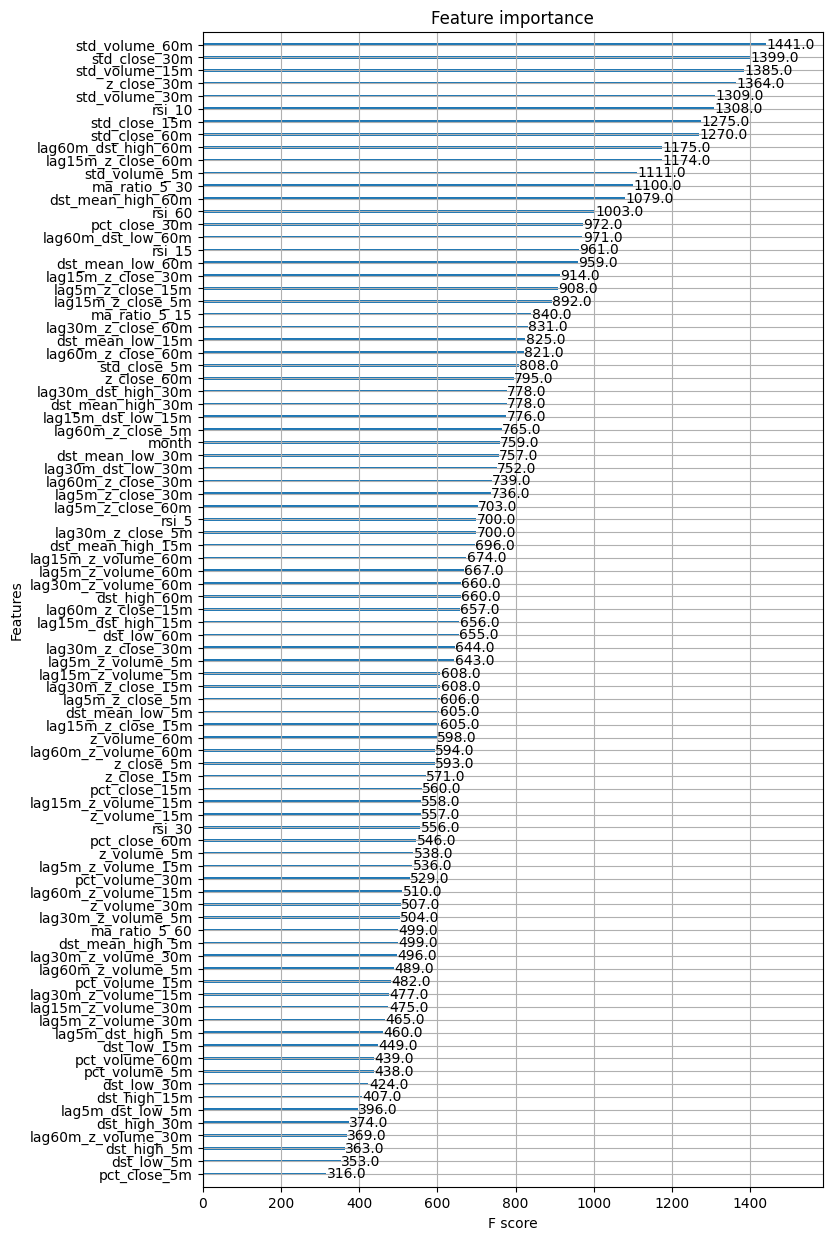

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 15))
xgb.plot_importance(clf, importance_type='weight', ax=ax)
plt.show()